[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/susannaruecker/NLP-workshop/blob/main/03a_BERT-classifier_PyTorch.ipynb)

In [39]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

### Load Data

In [40]:
os.makedirs('10kGNAD', exist_ok=True) # create folder in Colab

# download public 10kGNAD train and test data from github repo

url_train = 'https://raw.githubusercontent.com/tblock/10kGNAD/master/train.csv'
read_train = requests.get(url_train, allow_redirects=True)
open('10kGNAD/train.csv', 'wb').write(read_train.content)

url_test = 'https://raw.githubusercontent.com/tblock/10kGNAD/master/test.csv'
read_test = requests.get(url_test, allow_redirects=True)
open('10kGNAD/test.csv', 'wb').write(read_test.content)

2755020

### Prepare Dataframe

In [41]:
df_train = pd.read_csv("10kGNAD/train.csv", sep = ';', 
                       encoding = "utf-8", 
                       quotechar='\'', header=None, names = ["label", "article"])

df_test = pd.read_csv("10kGNAD/test.csv", sep = ';', 
                      encoding = "utf-8", 
                      quotechar='\'', header=None, names = ["label", "article"])


# use the LabelEncoder vom scklearn, and save the order/mapping for later
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
label_encoded=le.fit(df_train.label)
print(le.classes_)

label_to_id = {c: i for (i, c) in enumerate(le.classes_)}
print(label_to_id)

id_to_label = {v: k for k, v in label_to_id.items()}
print(id_to_label)

df_train["label_id"] = df_train.label.map(label_to_id)
df_test["label_id"] = df_test.label.map(label_to_id)

print("\nShapes:", df_train.shape, df_test.shape)

['Etat' 'Inland' 'International' 'Kultur' 'Panorama' 'Sport' 'Web'
 'Wirtschaft' 'Wissenschaft']
{'Etat': 0, 'Inland': 1, 'International': 2, 'Kultur': 3, 'Panorama': 4, 'Sport': 5, 'Web': 6, 'Wirtschaft': 7, 'Wissenschaft': 8}
{0: 'Etat', 1: 'Inland', 2: 'International', 3: 'Kultur', 4: 'Panorama', 5: 'Sport', 6: 'Web', 7: 'Wirtschaft', 8: 'Wissenschaft'}

Shapes: (9245, 3) (1028, 3)


### Install the Huggingface Transformer Library

* see https://huggingface.co/docs/transformers
* for PyTorch (e.g. `BertModel`) and Tensorflow/Keras (e.g.g `TFBertModel`)
* I think: in general preference is on PyTorch (documentation, support) and some models are only supported in PyTorch, but the "normal" ones can be used in Keras as well

In [42]:
!pip install transformers

### Importing Transformers and PyTorch

In [43]:
import transformers
from transformers import BertForSequenceClassification, BertTokenizer, AdamW     #, BertModel 

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [44]:
PRE_TRAINED_MODEL_NAME = 'bert-base-german-cased' # load checkpoint: German pretrained BERT, used for Tokenizer and Model

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME) # initialize BERT tokenizer 

In [45]:
# try out tokenizer methods

sample = "Ein wunderschöner Beispielsatz."
print(tokenizer.tokenize(sample))             # just tokenize, note the subtoken strategy (##)
print(tokenizer.encode(sample))               # get token ids, note the new 3 and 4 (CLS + SEP)
print(tokenizer.encode_plus(sample))          # some more advances things, could add padding/truncation, ...
print(tokenizer(sample))                      # seems to be the same

['Ein', 'wunder', '##schön', '##er', 'Beispiel', '##satz', '.']
[3, 198, 13051, 21114, 6, 2249, 685, 26914, 4]
{'input_ids': [3, 198, 13051, 21114, 6, 2249, 685, 26914, 4], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [3, 198, 13051, 21114, 6, 2249, 685, 26914, 4], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}


### Get an idea of text length in the data (look at impact of truncation/padding)

In [46]:
# iterate ofer text and get their "BERT"-length
# (took df_test just to save time, should be similar in df_train)
token_lens = []

for txt in df_test.article:
  tokens = tokenizer.encode(txt)
  token_lens.append(len(tokens))

Token indices sequence length is longer than the specified maximum sequence length for this model (576 > 512). Running this sequence through the model will result in indexing errors


Mean text length (in BERT tokens): 551.5428015564203


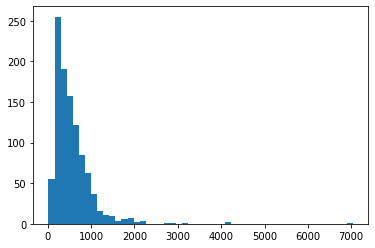

In [47]:
print("Mean text length (in BERT tokens):", np.mean(token_lens)) # mean token len in df_test
plt.hist(token_lens, 50); # distribution of text length in the corpus


# --> so it WOULD definitly be better to use the "full" 512 tokens... but this takes for ever... but keep that in mind, we do truncate A LOT!

### Creating Dataset and Dataloader, using the BERT tokenizer

* with PyTorch's Dataset we can combine Features (Articles) and their labels and return them as a dict for each sample
* we can put in some preprocessing steps (here: BERT Tokenizer, but could be image preprocessing or anything
* the Dataloader takes a Dataset and handles batching, shuffling

In [48]:
class ArticleDataset(Dataset):

  def __init__(self, content, tokenizer, max_len):
    self.content = content               # data source: our pd.DataFrame(s), this could be also done with lists or other
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.content)             # nr of samples
  
  def __getitem__(self, item):           # tell Dataset what to do with each raw sample --> BERT tokenize
    text = self.content.iloc[item].article
    label = self.content.iloc[item].label_id
    
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,           # add CLS, SEP and PAD
      max_length=self.max_len,
      truncation=True,                   # truncate long text
      padding='max_length',              # other possible options eg. pad to max length in batch, not padding, ... 
      return_token_type_ids=False,       # (I think) this would be for tasks with two sequences (question-answer)
      return_attention_mask=True,        # important: tells model what token is a real token and where padding starts (self-attention should not consider the padding tokens)
      return_tensors='pt',               # return PyTorch-Tensors
    )
  
    return {
          'text': text,                  # we don't use this, but maybe nice to keep
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label)
           }

In [49]:
MAX_LEN = 128 # note: we should use the full 512 but this takes a lot of time/memory space, so we truncate A LOT
              # maybe try 521 later (then you need to decrease batch size! cuda memory cannot handle it...)

ds_train = ArticleDataset(df_train, tokenizer, max_len = MAX_LEN)
ds_test = ArticleDataset(df_test, tokenizer, max_len = MAX_LEN)

In [50]:
ds_train[0] # look at one sample in Dataset

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([    3,  2439, 26935,   112,   352,   519,  5483,  2294,   255, 13936,
           147, 26914,  2319,     2, 12031,   428,  1080,  2294,   255, 13936,
           115,  4668, 14920,  2934,  3075,  7532, 26908, 11721, 26914,   233,
           106,  2942,   147, 21080,  3934, 26897,  2439, 26935,   112,   352,
           288, 14201,   785,  1131, 26964,   400, 26935,  2104, 20132, 15904,
           383,  1724, 10859, 26903,  3221,  1828,  6658, 18050,   270,   235,
          5180,   303,   717,  8246,    91,  2879,  443

In [51]:
BATCH_SIZE = 8
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=True)

In [52]:
len(dl_train), len(dl_test) # nr of batches in the DataLoaders (so depending on BATCH_SIZE and of cours nr of samples)

(1156, 129)

In [53]:
# have a look at one batch in DataLoader
data = next(iter(dl_train))
print(data.keys())
print(data["input_ids"].shape)
print(data["attention_mask"].shape)
print(data["label"].shape)

dict_keys(['text', 'input_ids', 'attention_mask', 'label'])
torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8])


## Now: Load the pretrained BERT Model

Two possibilities
* take `BertForsequenceClassification` (already implemented BERT + dense layer on top) **--> we do this here**
    * models like that exists for some of the "basic" tasks:
    * `BertForSequenceClassification, BertForMultipleChoice, BertForTokenClassification, BertForQuestionAnswering`
* OR: take original `BertModel` and implement your own output layer using PyTorch code
    * --> similar to what is/was done in [AI-NLP-Article-Engagement](https://github.com/INWT/AI-NLP-article-engagement/blob/master/article_engagement/src/bertFFN.py)

In [54]:
model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, # the same German checkpoint that was already used in the tokenizer
                                                      num_labels = 9 # we have 9 labels in our data (if we put num_labels == 1 this turns into a regression task! very handy!)
                                                      )

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

### Send model to GPU

Be aware, in PyTorch you need to do that explicitly, in Keras you don't. Note that you have to put other things (data, loss function) `.to(device)` as well, otherwise you will get errors telling you to do so...

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [56]:
model = model.to(device)

In [57]:
# send one batch through the (not yet trained) model, have a look at the output (--> logits)

model(data["input_ids"].to(device), data["attention_mask"].to(device))

SequenceClassifierOutput([('logits',
                           tensor([[-0.2260,  0.1474,  0.0099,  0.1190, -0.1817, -0.2716, -0.1496,  0.6311,
                                     0.2201],
                                   [ 0.3065,  0.2186,  0.0151,  0.2264, -0.1483, -0.3388,  0.1572,  0.7573,
                                     0.3756],
                                   [ 0.2807,  0.2899,  0.3446,  0.2152, -0.0726, -0.4700,  0.0666,  0.5800,
                                     0.0884],
                                   [ 0.3552, -0.1453,  0.1012,  0.1631, -0.1879,  0.0434, -0.0229,  0.5774,
                                    -0.0543],
                                   [ 0.2460,  0.1761,  0.1070,  0.3900, -0.2337, -0.3426,  0.1424,  0.4899,
                                     0.1837],
                                   [ 0.0899, -0.1448, -0.0224,  0.3451,  0.0679, -0.2980, -0.2249,  0.9833,
                                     0.1172],
                                   [ 0.

### Define Optimizer and Loss Fuction

In [58]:
optimizer = AdamW(model.parameters(), lr = 2e-5)
loss_fn = nn.CrossEntropyLoss().to(device)

EPOCHS = 15

## Now: The whole training loop (with evaluation loop inside)

Unlike in Keras, you have to implement this yourself!

I know, it looks a bit confusing/overwhelming when you would just like somethong as pretty as model.fit() while having such a "simple" setup... But the flexibility can be very cool! You can do gradient accumulation, evaluate at specific times, print outputs/log whenever you like, define your own metrics, ...

In [59]:
history = defaultdict(list) # for saving accuracy and loss (for plotting later)

for e in range(EPOCHS):
  print(f"Epoch {e}\n----------------")
  
  ########## TRAINING ###########

  print("training...")
  model = model.train()
  losses = []
  correct_predictions = 0
  seen_samples = 0
  for n, d in enumerate(dl_train):
    print("\r---at batch nr", n, end = "")
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["label"].to(device)
    seen_samples += len(labels) # count all samples
    outputs = model(input_ids=input_ids,
                    attention_mask=attention_mask
                   )["logits"]
    _, preds = torch.max(outputs, dim=1) # get predicted labels from the logits (torch.max() returns tupel (max, max_indices), we want the index = label)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if n > 100: # just for time reasons break after N batches, of course you wold NOT do that in real life!
      break
  
  print(f"\nCorrect predictions {correct_predictions.cpu().detach().numpy()} of {seen_samples} seen samples")
  print("So Accuracy of:", (correct_predictions.cpu().detach().numpy()/seen_samples).round(4))
  print("Mean loss:", np.mean(losses).round(4))

  history['train_acc'].append((correct_predictions.cpu().detach().numpy()/seen_samples).round(4))
  history['train_loss'].append(np.mean(losses).round(4))

  ########## EVALUATION ###########

  print("   evaluating...")
  model = model.eval()
  losses = []
  correct_predictions = 0
  seen_samples = 0
  with torch.no_grad():
    for n, d in enumerate(dl_test):
      print("\r   ---at batch nr", n, end = "")
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      seen_samples += len(labels)
      outputs = model(input_ids=input_ids,
                    attention_mask=attention_mask
                    )["logits"]
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  print(f"\n   Correct predictions {correct_predictions.cpu().detach().numpy()} of {seen_samples} seen samples")
  print("   So Accuracy of:", (correct_predictions.cpu().detach().numpy()/seen_samples).round(4))
  print("   Mean loss:", np.mean(losses).round(4))

  history['val_acc'].append((correct_predictions.cpu().detach().numpy()/seen_samples).round(4))
  history['val_loss'].append(np.mean(losses).round(4))

  

Epoch 0
----------------
training...
---at batch nr 101
Correct predictions 466 of 816 seen samples
So Accuracy of: 0.5711
Mean loss: 1.3761
   evaluating...
   ---at batch nr 128
   Correct predictions 808 of 1028 seen samples
   So Accuracy of: 0.786
   Mean loss: 0.7606
Epoch 1
----------------
training...
---at batch nr 101
Correct predictions 676 of 816 seen samples
So Accuracy of: 0.8284
Mean loss: 0.5847
   evaluating...
   ---at batch nr 128
   Correct predictions 850 of 1028 seen samples
   So Accuracy of: 0.8268
   Mean loss: 0.5449
Epoch 2
----------------
training...
---at batch nr 101
Correct predictions 686 of 816 seen samples
So Accuracy of: 0.8407
Mean loss: 0.5249
   evaluating...
   ---at batch nr 128
   Correct predictions 858 of 1028 seen samples
   So Accuracy of: 0.8346
   Mean loss: 0.5015
Epoch 3
----------------
training...
---at batch nr 101
Correct predictions 697 of 816 seen samples
So Accuracy of: 0.8542
Mean loss: 0.472
   evaluating...
   ---at batch nr 1

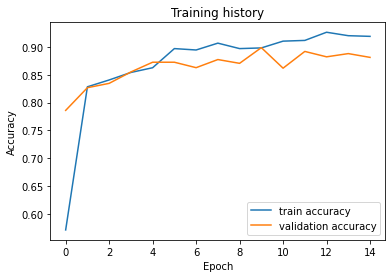

In [77]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend();

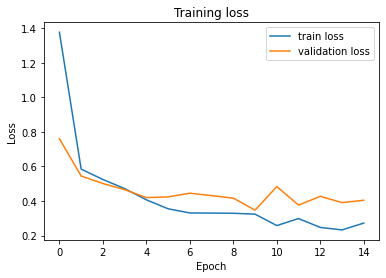

In [78]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend();

In [79]:
#### again on test, to get classification report

In [80]:
model = model.eval()
predictions = []
logits = []
true_labels = []
with torch.no_grad():
  for n, d in enumerate(dl_test):
    print("\r---at batch nr", n, end = "")
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["label"].to(device)
    outputs = model(input_ids=input_ids,
                  attention_mask=attention_mask
                  )["logits"]
    _, preds = torch.max(outputs, dim=1)
    predictions.extend(preds)
    logits.extend(outputs)
    true_labels.extend(labels)

predictions = torch.stack(predictions).cpu()
logits = torch.stack(logits).cpu()
true_labels = torch.stack(true_labels).cpu()

---at batch nr 128

In [81]:
from sklearn.metrics import confusion_matrix, classification_report

In [82]:
print(true_labels[:15])
print(predictions[:15])
#print(logits)

tensor([6, 6, 4, 7, 2, 6, 6, 5, 6, 5, 0, 6, 0, 4, 2])
tensor([6, 6, 4, 7, 2, 0, 6, 5, 6, 5, 4, 6, 0, 4, 2])


In [83]:
print(classification_report(true_labels, predictions, target_names=list(le.classes_)))

               precision    recall  f1-score   support

         Etat       0.90      0.84      0.87        67
       Inland       0.90      0.78      0.84       102
International       0.93      0.79      0.85       151
       Kultur       0.89      0.89      0.89        54
     Panorama       0.71      0.95      0.81       168
        Sport       0.99      0.97      0.98       120
          Web       0.97      0.96      0.97       168
   Wirtschaft       0.87      0.85      0.86       141
 Wissenschaft       0.94      0.79      0.86        57

     accuracy                           0.88      1028
    macro avg       0.90      0.87      0.88      1028
 weighted avg       0.89      0.88      0.88      1028



In [84]:
cm = confusion_matrix(true_labels, predictions)
pd.DataFrame(cm, index = list(le.classes_), columns = list(le.classes_))

,Etat,Inland,International,Kultur,Panorama,Sport,Web,Wirtschaft,Wissenschaft
Etat,56,1,1,1,6,0,1,1,0
Inland,0,80,1,2,12,0,0,7,0
International,1,0,119,0,25,1,0,5,0
Kultur,1,0,0,48,2,0,0,1,2
Panorama,1,1,2,2,159,0,1,1,1
Sport,0,0,0,0,3,117,0,0,0
Web,3,0,0,1,0,0,162,2,0
Wirtschaft,0,5,3,0,11,0,2,120,0
Wissenschaft,0,2,2,0,6,0,1,1,45


### And again to our own texts!

In [85]:
new_texts = [
             """Der Südbadische Fußballverband (SBFV) hat auf die aktuelle Entwicklung in der Corona-Pandemie reagiert. Der Verbandsvorstand beschloss am Abend, mit dem Spielbetrieb in allen 
             südbadischen Alters- und Spielklassen von der Verbandsliga abwärts vorzeitig in die Winterpause zu gehen.""",
             
             """Vor dem Bund-Länder-Gespräch über weitere Einschränkungen und Verbote werden die Forderungen nach einem harten Lockdown lauter. Der Präsident des Städtetages Baden-Württemberg, 
             Mannheims Oberbürgermeister Peter Kurz (SPD), hält ihn für nötig, wenn sich die Corona-Lage in den kommenden Tagen weiter verschärft.
             """,
             
             """Dank einer taktischen Umstellung für die letzten fünf Spielminuten und dem viel zitierten Spielglück haben die Basketballerinnen des USC Freiburg ihren Heimnimbus in dieser Saison gewahrt und sich in der 
             Spitzengruppe der Bundesliga festgekrallt. Am Samstagabend gewannen die Eisvögel im sechsten Spiel in der Unihalle zum sechsten Mal
             """,
             
             """Abgesehen von pandemiegeschuldeter Einlasskontrolle und Maskenpflicht war es wie früher: das Freiburger Konzerthaus – ausverkauft! Kein Wunder, wenn die aus Südbaden stammende Weltklasse-Geigerin 
             Anne-Sophie Mutter und ihre seit nunmehr zehn Jahren bestehenden Mutter’s Virtuosi auftreten. Mittelpunkt und Rahmen jetzt: Antonio Vivaldi.
             """,
             
             """Ja, es ist ein Jugendstück. Anton Tschechow war 18 Jahre alt, als er es schrieb - und wieder vernichtete, nachdem es kein Gehör gefunden hatte. 
             Die Erstschrift hat sich erhalten und wurde 1920 unter dem – nicht von Tschechow stammenden – Titel "Platonow" veröffentlicht. Eine Jugendsünde ist es nicht, 
             denn viele Motive aus dem späteren Werk klingen an. Nur: Wenn man es vom Blatt spielte, dauerte die Aufführung geschlagene sechs Stunden, länger als jede Wagner-Oper. 
             """
]

In [86]:
encoding = tokenizer.batch_encode_plus(
      new_texts,
      add_special_tokens=True,
      max_length=MAX_LEN,
      truncation=True,
      padding='max_length',
      return_token_type_ids=False,
      return_attention_mask=True,
      return_tensors='pt',
      )
      

In [87]:
encoding

{'input_ids': tensor([[    3,   233,  1012,  8616,   262,  1820,  2884, 26954,    24, 26925,
         26934, 26937, 26955,   193,   115,    30,  8974,  2503,    50,    21,
          6471,  4045, 26935,  5402,   492,    12, 12155, 26914,   233, 10664,
         11148, 11216,   235,  4253, 26918,   114,   128, 23491,    50,  2122,
          1722,  8616,   156,  4963, 26935,    42, 13354, 26898,    88,    21,
         10664,  2640,   281,  5538, 15723,    50,    30,  2942, 13034,    81,
          2860, 26914,     4,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [88]:
logits = model(encoding["input_ids"].to(device), encoding["attention_mask"].to(device))["logits"]
logits

tensor([[-9.3697e-01, -1.2233e+00, -8.2046e-01, -7.6683e-01, -6.3095e-01,
          6.3795e+00, -1.2225e+00,  7.3657e-02, -8.4601e-01],
        [-1.1978e+00, -5.1615e-01,  2.2966e+00, -1.2609e+00,  5.2776e+00,
         -1.6379e+00, -1.4198e+00, -2.5653e-01, -2.4430e+00],
        [-1.3018e+00, -1.5899e+00, -1.0086e+00, -1.2734e-01, -4.9290e-01,
          6.6941e+00, -8.1865e-01, -8.0392e-01, -6.5158e-01],
        [ 5.1066e-01, -1.3062e+00, -1.0228e+00,  4.9467e+00,  1.2161e-01,
         -2.4578e-01, -1.3232e+00, -2.5225e-02, -1.0383e+00],
        [ 3.9796e-01, -1.3569e+00, -9.8029e-01,  5.2060e+00, -3.0482e-04,
         -9.7131e-01, -1.2378e+00, -4.8866e-01,  5.0814e-03]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [89]:
_, preds = torch.max(logits, dim=1)
preds.cpu().detach().numpy()

array([5, 4, 5, 3, 3])

In [90]:
print( [ (l, id_to_label[l]) for l in preds.cpu().detach().numpy() ])

[(5, 'Sport'), (4, 'Panorama'), (5, 'Sport'), (3, 'Kultur'), (3, 'Kultur')]


### Appendix: Try out Tokenizer and BertModel, ...

In [91]:
sample1 = "Das ist ein Beispieltext."
sample2 = "" # empty sentence

encoding1 = tokenizer.encode_plus(
              sample1,
              add_special_tokens=True,
              max_length=20,
              truncation=True,
              padding='max_length',
              return_token_type_ids=False,
              return_attention_mask=True,
              return_tensors='pt',
            )

encoding2 = tokenizer.encode_plus(
              sample2,
              add_special_tokens=True,
              max_length=20,
              truncation=True,
              padding='max_length',
              return_token_type_ids=False,
              return_attention_mask=True,
              return_tensors='pt',
            )

In [93]:
print(tokenizer.tokenize(sample2))
print(tokenizer.encode(sample2))

[]
[3, 4]


In [95]:
from transformers import BertModel
bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) # new pretrained (but not our fine tuned) model

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [121]:
encoding1.keys()

dict_keys(['input_ids', 'attention_mask'])

In [131]:
output = bert(**encoding1)

In [132]:
output.keys() # pooler_output is CLS-representation (+ some internal dense layer)
              # last_hidden_state is representation for each token in sequence

odict_keys(['last_hidden_state', 'pooler_output'])

In [133]:
output["pooler_output"].shape, output["last_hidden_state"].shape

(torch.Size([1, 768]), torch.Size([1, 20, 768]))

In [134]:
hidden_states = output["last_hidden_state"].squeeze() # squeeze to get rid of batch_size = 1 at the beginning

In [135]:
hidden_states[:,:5] # only the first 8 rows correspond to real tokens, rest is padding
                    # weird: the PAD tokens still get different representations! (positional embeddings)

tensor([[ 8.3144e-02,  5.8297e-01,  3.2806e-01,  4.7019e-01,  7.3265e-01],
        [-4.1364e-01,  2.2340e-01, -1.9122e-02,  3.1044e-01,  1.6804e+00],
        [ 3.7790e-01, -6.5793e-01, -5.6755e-01,  3.1947e-01,  1.0292e+00],
        [ 2.9778e-02,  2.8914e-02,  4.8572e-01,  1.6816e-01,  1.0377e+00],
        [-1.9187e-01,  6.1165e-02,  1.2330e+00,  3.6894e-01,  7.1212e-01],
        [ 3.4061e-04,  4.1001e-01,  8.5165e-01,  8.2820e-01,  1.0654e+00],
        [-7.3688e-03,  3.1385e-01, -1.3910e-01,  3.5845e-01,  7.4667e-01],
        [ 2.1039e-01,  1.1372e+00,  6.1119e-01,  1.0047e+00,  1.9506e+00],
        [ 4.5072e-03,  5.9529e-01,  1.4325e-01,  4.8961e-01,  7.8408e-01],
        [-1.1314e-01,  5.7688e-01,  2.0541e-01,  3.4408e-01,  5.8928e-01],
        [-3.0372e-01,  7.2950e-01, -3.8838e-02,  2.5796e-01,  4.4587e-01],
        [ 4.1402e-02, -5.7078e-02, -2.3804e-01,  2.8401e-01,  3.0455e-01],
        [-1.0576e-02,  1.1249e-01, -1.4327e-01,  2.7651e-01,  5.4806e-01],
        [-1.9754e-02,  5.

In [136]:
encoding1["input_ids"]

tensor([[    3,   295,   127,    39,  2249,  8859, 26914,     4,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])

In [137]:
output["pooler_output"][:,:5] # not the same as CLS hidden state because "pooler_output" adds a linear transformation ion top (docu says so...)

tensor([[ 0.9999, -0.1840, -0.0846,  0.2455, -0.0198]],
       grad_fn=<SliceBackward0>)